<a href="https://colab.research.google.com/github/nadiapljcode/EyeDiseaseClassification/blob/main/EyeDeepNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EYE DEEPNET: MULTICLASS RETINAL DISEASE DIAGNOSIS USING DEEP NEURAL NETWORKS

In [ ]:
#import require python classes and packages
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
import pickle
from sklearn.metrics import confusion_matrix #class to calculate accuracy and other metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import seaborn as sns#data visualization
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint
import keras
from keras import Model, layers
import pandas as pd
from keras.optimizers import SGD #import SGD class
from keras.optimizers import Adam #import Adam class optimizer
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout

Using TensorFlow backend.
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [ ]:
#define global variables
X = []
Y = []
path = "SelectedImages"
labels = []

In [ ]:
#define function to load class labels
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index
print("Retinal Diseases Class Labels found in dataset : "+str(labels))

Retinal Diseases Class Labels found in dataset : ['DR', 'MH', 'Normal', 'ODC']


In [ ]:
#loop and read all images from dataset
if os.path.exists('model/X.txt.npy'):#if images already processed then load all images
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else:#if not processed then read and process each image
    X = []
    Y = []
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read image
                img = cv2.resize(img, (32, 32))#resize image
                X.append(img)#addin images features to training array
                label = getLabel(name)
                Y.append(label)
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)
print("Dataset Loading Completed")
print("Total images found in dataset Before Augmentation : "+str(X.shape[0]))

Dataset Loading Completed
Total images found in dataset Before Augmentation : 1376


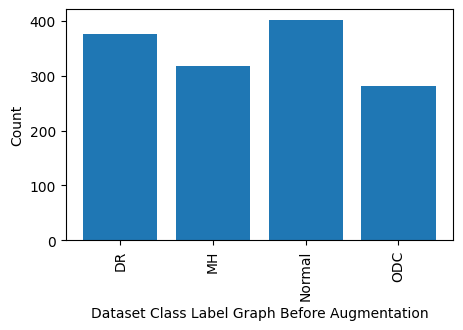

In [ ]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (5, 3))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph Before Augmentation")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [ ]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
#now apply augmentation on splitted train images
if os.path.exists('model/aug_X.txt.npy'):
    X = np.load('model/aug_X.txt.npy')
    Y = np.load('model/aug_Y.txt.npy')
else:
    aug = ImageDataGenerator(rotation_range=15, shear_range=0.8, horizontal_flip=True)#apply augmentation to increase images
    data = aug.flow(X_train, y_train, 1)
    X = []
    Y = []
    for x, y in data:
        x = x[0]
        y = y[0]
        X.append(x)
        Y.append(y)
        if len(Y) > 30000:
            break
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/aug_X.txt',X)
    np.save('model/aug_Y.txt',Y)
print("Image Augmentation Completed")
print("Total images found in dataset After Augmentation : "+str(X.shape[0]))

Image Augmentation Completed
Total images found in dataset After Augmentation : 30001


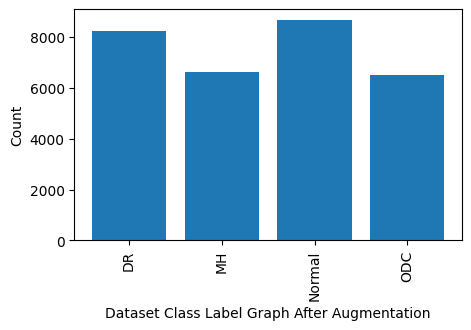

In [ ]:
#plotting graph of augmented images class labels
names, count = np.unique(np.argmax(Y, axis=1), return_counts=True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (5, 3))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph After Augmentation")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [ ]:
#split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print("Training Images Size   : "+str(X_train.shape[0]))
print("Validation Images Size : "+str(X_val.shape[0]))
print("Testing Images Size    : "+str(X_test.shape[0]))

Training Images Size   : 19200
Validation Images Size : 4800
Testing Images Size    : 6001


In [ ]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [ ]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))
    conf_matrix = confusion_matrix(y_test, predict)
    plt.figure(figsize =(6, 3))
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix")
    plt.xticks(rotation=90)
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()



EyeNet SGD Validation Accuracy  :  79.5
EyeNet SGD Testing Accuracy  :  79.77003832694551
EyeNet SGD Testing Precision : 79.76345106526747
EyeNet SGD Testing Recall    : 78.30570570450006
EyeNet SGD Testing FScore    : 78.37264429493744


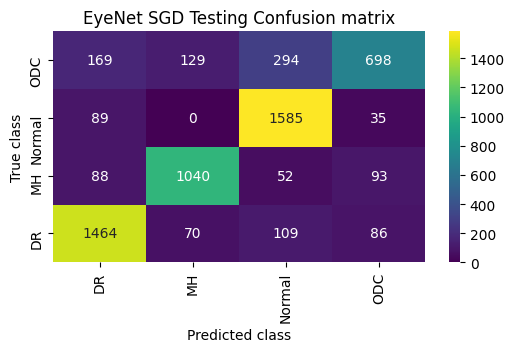

In [ ]:
#train eyenet model using SGD optimizer fixed learning rate
eyenet_model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=16, kernel_size=(9,9), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=8, kernel_size=(7,7), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=8, kernel_size=(6,6), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=8, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=8, kernel_size=(3,3), strides=(2,2), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(1,1), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(y_train.shape[1], activation='softmax')
])
#compiling, training and loading the model
opt = SGD(lr=0.001)
eyenet_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])#compiling the model
if os.path.exists("model/sgd_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/sgd_weights.hdf5', verbose = 1, save_best_only = True)
    hist = eyenet_model.fit(X_train, y_train, epochs = 40, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/sgd_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    eyenet_model.load_weights("model/sgd_weights.hdf5")
#perfrom prediction on test data
predict = eyenet_model.predict(X_val)
predict = np.argmax(predict, axis=1)
y_val1 = np.argmax(y_val, axis=1)
acc = accuracy_score(y_val1, predict) * 100
print("EyeNet SGD Validation Accuracy  :  "+str(acc))
predict = eyenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("EyeNet SGD Testing", predict, y_test1)

EyeNet Adam Validation Accuracy  :  83.04166666666667
EyeNet Adam Testing Accuracy  :  84.1859690051658
EyeNet Adam Testing Precision : 83.9053706225369
EyeNet Adam Testing Recall    : 83.52550633983233
EyeNet Adam Testing FScore    : 83.27277132627195


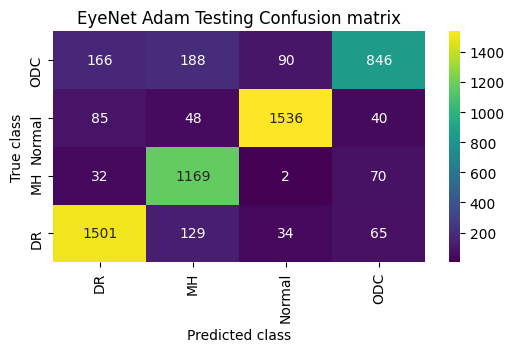

In [ ]:
#training EyeNet with Adam Optimizer
opt = Adam(lr=0.001)#defining Adam
eyenet_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])#compiling the model
#compiling, training and loading the model
if os.path.exists("model/adam_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/adam_weights.hdf5', verbose = 1, save_best_only = True)
    hist = eyenet_model.fit(X_train, y_train, epochs = 40, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/adam_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    eyenet_model.load_weights("model/adam_weights.hdf5")
#perfrom prediction on test data
predict = eyenet_model.predict(X_val)
predict = np.argmax(predict, axis=1)
y_val1 = np.argmax(y_val, axis=1)
acc = accuracy_score(y_val1, predict) * 100
print("EyeNet Adam Validation Accuracy  :  "+str(acc))
predict = eyenet_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("EyeNet Adam Testing", predict, y_test1)

Extension with Adam & Valid Padding Validation Accuracy  :  94.14583333333333
Extension with Adam & Valid Padding Testing Accuracy  :  94.86752207965338
Extension with Adam & Valid Padding Testing Precision : 94.52711153509668
Extension with Adam & Valid Padding Testing Recall    : 94.40576131943348
Extension with Adam & Valid Padding Testing FScore    : 94.38817265478255


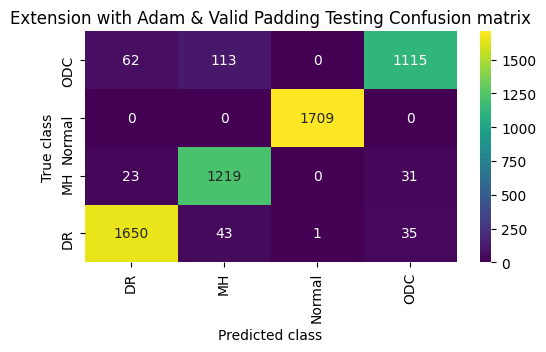

In [ ]:
#train extension model with padding as 'same and valid'
extension_model = Sequential()
extension_model.add(InputLayer(input_shape=(X_train.shape[1],X_train.shape[2],X_train.shape[3])))
extension_model.add(Conv2D(25, (5, 5), activation='relu', strides=(1, 1), padding='same'))
extension_model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
extension_model.add(Conv2D(50, (5, 5), activation='relu', strides=(2, 2), padding='same'))
extension_model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
extension_model.add(BatchNormalization())
extension_model.add(Conv2D(70, (3, 3), activation='relu', strides=(2, 2), padding='same'))
extension_model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
extension_model.add(BatchNormalization())
extension_model.add(Flatten())
extension_model.add(Dense(units=100, activation='relu'))
extension_model.add(Dense(units=100, activation='relu'))
extension_model.add(Dropout(0.25))
extension_model.add(Dense(units=y_train.shape[1], activation='softmax'))
extension_model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
if os.path.exists("model/extension_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/extension_weights.hdf5', verbose = 1, save_best_only = True)
    hist = extension_model.fit(X_train, y_train, epochs = 40, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/extension_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()
else:
    extension_model.load_weights("model/extension_weights.hdf5")
#perfrom prediction on test data
predict = extension_model.predict(X_val)
predict = np.argmax(predict, axis=1)
y_val1 = np.argmax(y_val, axis=1)
acc = accuracy_score(y_val1, predict) * 100
print("Extension with Adam & Valid Padding Validation Accuracy  :  "+str(acc))
predict = extension_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
calculateMetrics("Extension with Adam & Valid Padding Testing", predict, y_test1)

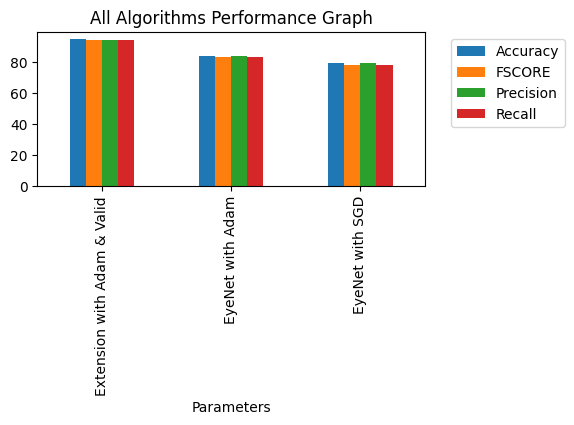

In [ ]:
#comparison graph
df = pd.DataFrame([['EyeNet with SGD','Accuracy',accuracy[0]],['EyeNet with SGD','Precision',precision[0]],['EyeNet with SGD','Recall',recall[0]],['EyeNet with SGD','FSCORE',fscore[0]],
                   ['EyeNet with Adam','Accuracy',accuracy[1]],['EyeNet with Adam','Precision',precision[1]],['EyeNet with Adam','Recall',recall[1]],['EyeNet with Adam','FSCORE',fscore[1]],
                   ['Extension with Adam & Valid','Accuracy',accuracy[2]],['Extension with Adam & Valid','Precision',precision[2]],['Extension with Adam & Valid','Recall',recall[2]],['Extension with Adam & Valid','FSCORE',fscore[2]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(5, 2))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("All Algorithms Performance Graph")

plt.show()

In [ ]:
(len(accuracy))

3

In [ ]:
#display all algorithm performnace
algorithms = ['EyeNet with SGD','Extension with Adam & Valid']
data = []
for i in range(len(accuracy)-1):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,EyeNet with SGD,79.770038,79.763451,78.305706,78.372644
1,Extension with Adam & Valid,84.185969,83.905371,83.525506,83.272771


In [ ]:
def values(filename, acc, loss):
    f = open(filename, 'rb')
    train_values = pickle.load(f)
    f.close()
    accuracy_value = train_values[acc][0:20]
    loss_value = train_values[loss][0:20]
    return accuracy_value, loss_value

c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  # Remove the CWD from sys.path while we load stuff.
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()
c:\users\dell\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  if sys.path[0] == "":


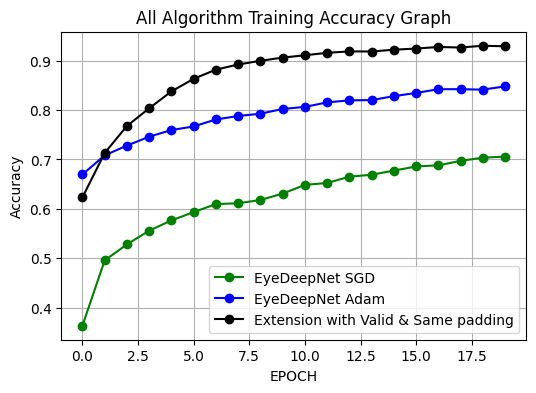

In [ ]:
#accuracy graph
sgd_acc, sgd_loss = values("model/sgd_history.pckl", "accuracy", "loss")
adam_acc, adam_loss = values("model/adam_history.pckl", "accuracy", "loss")
extension_acc, extension_loss = values("model/extension_history.pckl", "accuracy", "loss")

plt.figure(figsize=(6,4))
plt.grid(True)
plt.xlabel('EPOCH')
plt.ylabel('Accuracy')
plt.plot(sgd_acc, 'ro-', color = 'green')
plt.plot(adam_acc, 'ro-', color = 'blue')
plt.plot(extension_acc, 'ro-', color = 'black')
plt.legend(['EyeDeepNet SGD', 'EyeDeepNet Adam', 'Extension with Valid & Same padding'], loc='lower right')
plt.title('All Algorithm Training Accuracy Graph')
plt.show()

In [ ]:
#use this function to predict Eye diseases uisng extension model output
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (32,32))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,32,32,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    predict = extension_model.predict(img)#perform prediction on test image
    predict = np.argmax(predict)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (400,300))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    cv2.putText(img, 'Predicted As : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
    plt.figure(figsize=(4,3))
    plt.imshow(img)

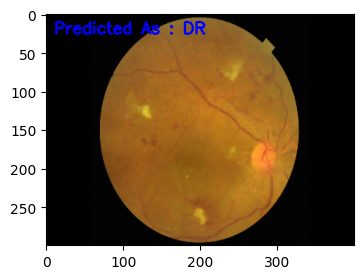

In [ ]:
#call this function to predict retinal diseases
predict("testImages/0.png")

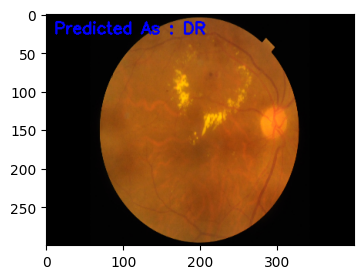

In [ ]:
#call this function to predict retinal diseases
predict("testImages/1.png")

In [ ]:
#call this function to predict retinal diseases
predict("testImages/4.png")

NameError: name 'predict' is not defined

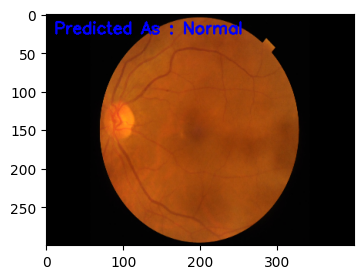

In [ ]:
#call this function to predict retinal diseases
predict("testImages/7.png")

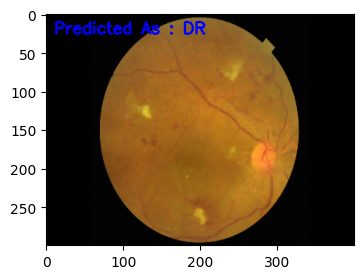

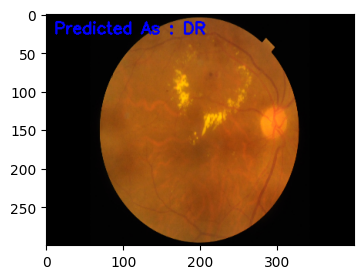

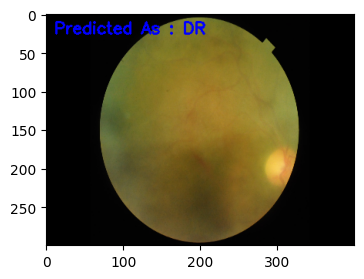

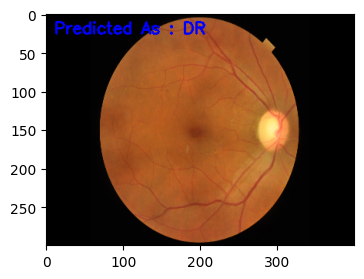

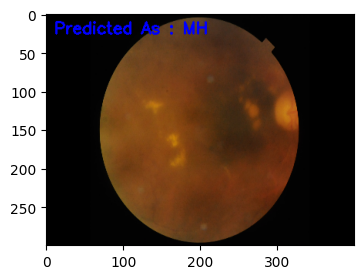

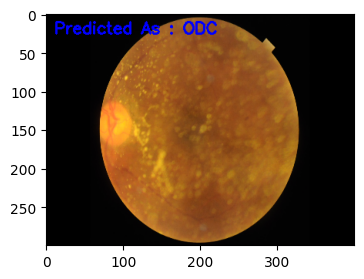

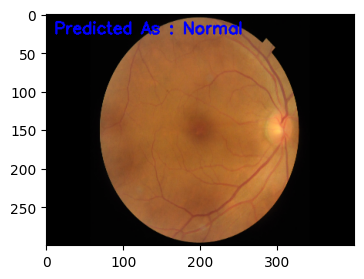

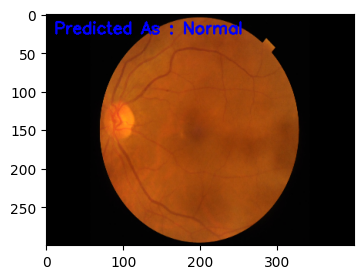

In [ ]:
predict("testImages/0.png")
predict("testImages/1.png")
predict("testImages/2.png")
predict("testImages/3.png")
predict("testImages/4.png")
predict("testImages/5.png")
predict("testImages/6.png")
predict("testImages/7.png")